In [1]:
import numpy as np, pandas as pd, seaborn as sns, os, json
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from fbprophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
import lightgbm

plt.rcParams['figure.figsize']=(13, 5)
path = '/Users/argosaakan/Data'

## Загрузка и подготовка дынных

In [2]:
# Загрузим данные
df = pd.read_csv(os.path.join(path, 'analytics.csv'), names=['id', 'created_at', 'progress', 'state', 'status', 'activity_id', 'user_id'], parse_dates=['created_at'])
df.head()

,id,created_at,progress,state,status,activity_id,user_id
0,24725,2020-03-01 06:55:19.334442,0.10,NaN,0,53,104
1,24726,2020-03-01 06:55:20.645680,0.75,"{""read"":1,""listen"":0,""survey"":0,""answers"":{},""...",0,53,104
2,24727,2020-03-01 06:55:20.726646,0.75,"{""read"":1,""listen"":0,""survey"":0,""answers"":{},""...",1,53,104
3,24728,2020-03-01 06:58:46.499767,1.00,"{""read"":1,""listen"":0,""survey"":1,""answers"":{""11...",1,53,104
4,24729,2020-03-01 06:58:46.601173,1.00,"{""read"":1,""listen"":0,""survey"":1,""answers"":{""11...",2,53,104


In [3]:
# Посмотрим на типы данных
df.dtypes

id                      int64
created_at     datetime64[ns]
progress              float64
state                  object
status                  int64
activity_id             int64
user_id                 int64
dtype: object

In [4]:
# Посчитаем пропуски
df['state'].isna().sum()

1471

In [5]:
# Удалим строчки с пропущенными данными в колонке "state"
df.dropna(subset=['state'], inplace=True)
df.reset_index(drop=True, inplace=True)

In [6]:
# Развернем колонку 'state' в несколько колонок. Оставим те, в которых меньше 50% пропусков
state_df = pd.DataFrame(df['state'].apply(json.loads))
state_df = pd.json_normalize(data=state_df['state']).drop('listen', axis=1)
state_df.dropna(thresh=state_df.shape[0]*0.5, how='all', axis=1, inplace=True)
df = df.drop('state', axis=1).join(state_df)
df

,id,created_at,progress,status,activity_id,user_id,read,survey,sim
0,24726,2020-03-01 06:55:20.645680,0.750000,0,53,104,1,0.000000,0.000000
1,24727,2020-03-01 06:55:20.726646,0.750000,1,53,104,1,0.000000,0.000000
2,24728,2020-03-01 06:58:46.499767,1.000000,1,53,104,1,1.000000,0.000000
3,24729,2020-03-01 06:58:46.601173,1.000000,2,53,104,1,1.000000,0.000000
4,24731,2020-03-01 06:59:14.910892,0.333333,0,52,104,0,0.333333,0.000000
...,...,...,...,...,...,...,...,...,...
10344,36540,2020-05-31 23:55:14.297360,0.433333,0,74,8,0,0.000000,0.433333
10345,36541,2020-05-31 23:55:19.021708,0.544444,0,74,8,0,0.000000,0.544444
10346,36542,2020-05-31 23:55:26.237174,0.655556,0,74,8,0,0.000000,0.655556
10347,36543,2020-05-31 23:55:26.285349,1.000000,0,74,8,0,0.000000,1.000000


## Разведывательный анализ данных

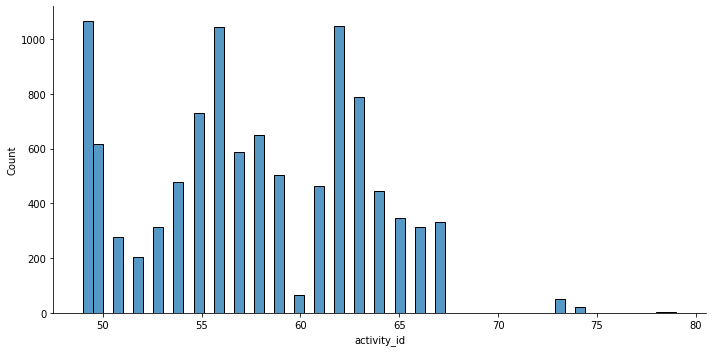

In [7]:
# Приглядимся к активностям
sns.displot(df['activity_id'], bins=59, kde=False, aspect=2)

In [8]:
# Топ 3 активности и количество "выполнений"
df['activity_id'].value_counts()[:3]

49    1066
62    1048
56    1045
Name: activity_id, dtype: int64

In [9]:
# Рассмотрим "статус" и "прогресс"
# Нет случаев, когда статус уже 2, а прогресс все еще не 1. Колонка progress пока работает корректно
df.loc[(df['progress'] != 1) & (df['status'] == 2)]

,id,created_at,progress,status,activity_id,user_id,read,survey,sim


In [10]:
# Это все примеры некорректной работы "статуса", так как прогресс показывает выполненную работу, а статус еще отображается как "не начал". По всей видимости, присутсвтует задеркжа обновления статуса
df.loc[(df['progress'] != 0) & (df['status'] == 0)].sort_values(['user_id', 'created_at']).head(15)

,id,created_at,progress,status,activity_id,user_id,read,survey,sim
2957,28095,2020-04-01 04:06:49.728658,0.750000,0,61,1,1,0.000000,0.000000
2959,28100,2020-04-01 06:06:50.452953,0.750000,0,59,1,1,0.000000,0.000000
3058,28220,2020-04-02 03:14:09.571849,0.750000,0,61,1,1,0.000000,0.000000
3060,28223,2020-04-02 03:30:06.680780,0.142857,0,57,1,0,0.142857,0.000000
3061,28224,2020-04-02 03:30:11.813689,0.285714,0,57,1,0,0.285714,0.000000
3062,28225,2020-04-02 03:30:14.755275,0.428571,0,57,1,0,0.428571,0.000000
3063,28226,2020-04-02 03:30:20.025599,0.571429,0,57,1,0,0.571429,0.000000
3064,28227,2020-04-02 03:30:23.577184,0.714286,0,57,1,0,0.714286,0.000000
3065,28228,2020-04-02 03:30:28.560041,0.857143,0,57,1,0,0.857143,0.000000
3078,28243,2020-04-02 05:01:23.405666,0.211111,0,55,1,0,0.000000,0.211111


In [11]:
# Значения в sim описываю насколько пользователь прошел данный этап. Соответственно, если в активности только одна часть (симуляция), то progress и sim совпадают. При этом, я вижу ситуации, когда прогресс (или симуляция) деградирует. То есть, по-видимому, предусмотрено такое, что при неверном решении, пользователь может уйти на «несколько шагов назад». Возможны и другие объяснения, нужно уточнять механику работы симулятора.
df.loc[df['activity_id'] > 50].sort_values(['activity_id', 'user_id']).iloc[60:65]

,id,created_at,progress,status,activity_id,user_id,read,survey,sim
1681,26645,2020-03-15 07:29:22.711308,0.666667,0,51,33,0,0.666667,0.0
1682,26646,2020-03-15 07:29:29.493042,0.166667,0,51,33,0,0.166667,0.0
1683,26647,2020-03-15 07:29:36.888503,0.333333,0,51,33,0,0.333333,0.0
1684,26648,2020-03-15 07:29:44.327584,0.500000,0,51,33,0,0.500000,0.0
1685,26649,2020-03-15 07:29:51.602207,0.666667,0,51,33,0,0.666667,0.0


<AxesSubplot:>

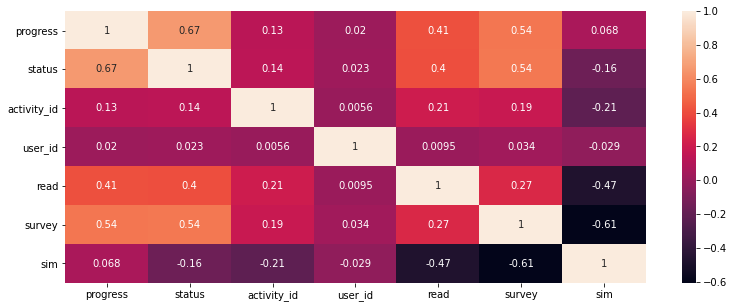

In [12]:
# Как и ожидалось, видим корреляцию между прогрессом и статусом. Также видим, что если в активности есть симуляция, то высока вероятность, что опроса или чтения уже не будет. Опрос с чтением положительно коррелируют, хоть и не сильно
sns.heatmap(df.drop(['created_at', 'id'], axis=1).corr(), annot=True)

<BarContainer object of 3 artists>

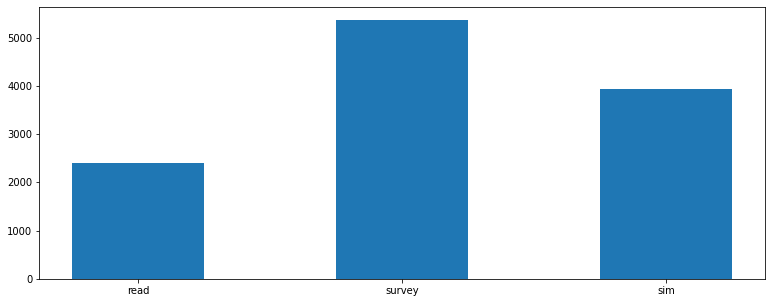

In [13]:
# Посмотрим какой тип задач в активностях привалирует
surveys_amount = df.loc[df['survey'] != 0].shape[0]
reads_amount = df.loc[df['read'] != 0].shape[0]
sims_amount = df.loc[df['sim'] != 0].shape[0]

fig, ax  = plt.subplots()
ax.bar([1, 3, 5], [reads_amount, sims_amount, surveys_amount], width=1, tick_label=['read', 'survey', 'sim'], align='center')

In [14]:
# Посчитаем по каждому курсу процент успешного прохождения (поймем есть ли курсы, которые часто бросают)

# Сгруппируем данные по активности и пользователю
df_abandoned_full = df[['activity_id', 'user_id', 'id']].groupby(['activity_id', 'user_id']).count()
df_abandoned_full = df_abandoned_full.rename(columns={'id': 'all actions'})

# Добавим колонку с такой же группировкой, но теперь без строк, где статус - "пройден"
df_abandoned_full['no ending'] = df[['activity_id', 'user_id', 'id']].loc[df['status'] != 2].groupby(['activity_id', 'user_id']).count()

# Теперь сгруппируем по активности и посчитаем сколько раз зан ее брались
df_abandoned = pd.DataFrame({'all actions': df_abandoned_full['all actions'].groupby('activity_id').count()})

# Добавим колонку, в которой отразим количество незаверншенных попыток
df_abandoned['abandoned'] = (df_abandoned_full['all actions'] == df_abandoned_full['no ending']).groupby('activity_id').sum()

# Уберем активности с количеством попыток меньше 11
df_abandoned = df_abandoned.loc[df_abandoned['all actions'] > 10]

# Добавим колонку с процентом успешного прохождения
df_abandoned['completd %'] = 100 - df_abandoned['abandoned'] * 100 / df_abandoned['all actions']

df_abandoned

,all actions,abandoned,completd %
activity_id,,,
49,78,1,98.717949
50,82,3,96.341463
51,34,0,100.000000
52,50,0,100.000000
53,79,3,96.202532
54,81,4,95.061728
55,91,2,97.802198
56,94,4,95.744681
57,68,5,92.647059


<AxesSubplot:xlabel='activity_id', ylabel='completd %'>

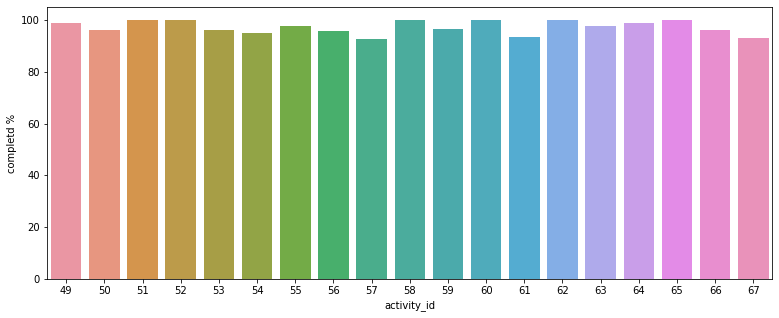

In [15]:
# Посмотрим на проценты успешного прохождения активностей
sns.barplot(x=df_abandoned.index, y=df_abandoned['completd %'])

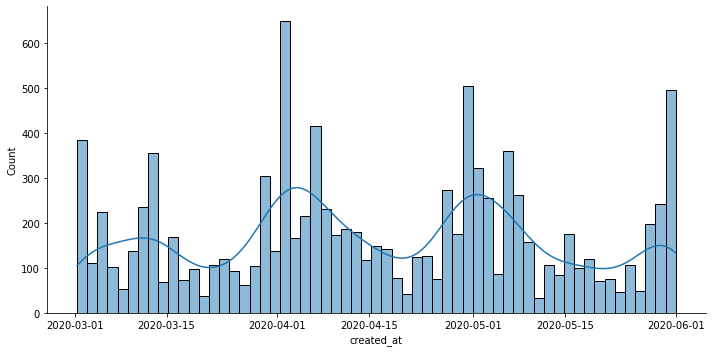

In [16]:
# Обратим внимание на месячную сезонность
sns.displot(df['created_at'], bins=59, kde=True, aspect=2)

## Кластеризация

In [17]:
# Нормализуем данные, чтобы алгоритм кластеризации не был biased к одной из переменных
scaler = MinMaxScaler()
df_cluster = df.drop(['id', 'created_at'], axis=1)
df_norm = pd.DataFrame(scaler.fit_transform(df_cluster))
df_norm

,0,1,2,3,4,5,6
0,0.727273,0.0,0.133333,0.517588,1.0,0.000000,0.000000
1,0.727273,0.5,0.133333,0.517588,1.0,0.000000,0.000000
2,1.000000,0.5,0.133333,0.517588,1.0,1.000000,0.000000
3,1.000000,1.0,0.133333,0.517588,1.0,1.000000,0.000000
4,0.272727,0.0,0.100000,0.517588,0.0,0.333333,0.000000
...,...,...,...,...,...,...,...
10344,0.381818,0.0,0.833333,0.035176,0.0,0.000000,0.433333
10345,0.503030,0.0,0.833333,0.035176,0.0,0.000000,0.544444
10346,0.624243,0.0,0.833333,0.035176,0.0,0.000000,0.655556
10347,1.000000,0.0,0.833333,0.035176,0.0,0.000000,1.000000


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

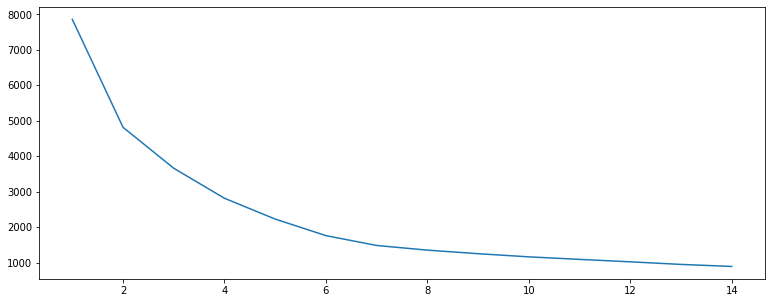

In [18]:
# Воспользуемся методом "локтя" для нахождения оптимального количества кластеров
sum_of_squared_distances_1 = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_norm)
    sum_of_squared_distances_1.append(km.inertia_)

sns.lineplot(K, sum_of_squared_distances_1)

In [19]:
# Разделим на выбранное количество кластеров
km = KMeans(n_clusters=7, random_state=0).fit(df_norm)
df_cluster['Classes'] = km.labels_

In [20]:
# Посмотрим на типичные даныые полученных кластеров
df_cluster.groupby('Classes').median()

,progress,status,activity_id,user_id,read,survey,sim
Classes,,,,,,,
0,0.666667,0,58,75,0,0.666667,0.000000
1,0.655556,0,56,72,0,0.000000,0.655556
2,0.750000,1,59,74,1,0.000000,0.000000
3,0.322222,0,56,73,0,0.000000,0.322222
4,1.000000,1,59,75,1,1.000000,0.000000
5,1.000000,2,56,75,0,0.000000,1.000000
6,1.000000,1,58,77,0,1.000000,0.000000


In [21]:
# Посмотрим на самого частовстречающегося представителя из класса 6
df_cluster.loc[df_cluster['Classes'] == 6].mode()

,progress,status,activity_id,user_id,read,survey,sim,Classes
0,1.0,1,58,111,0,1.0,0.0,6


## Прогнозирование

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  del sys.path[0]
Средняя абсолютная ошибка, почасовой прогноз: 6.94 или же 1.4593003165972276e+16%


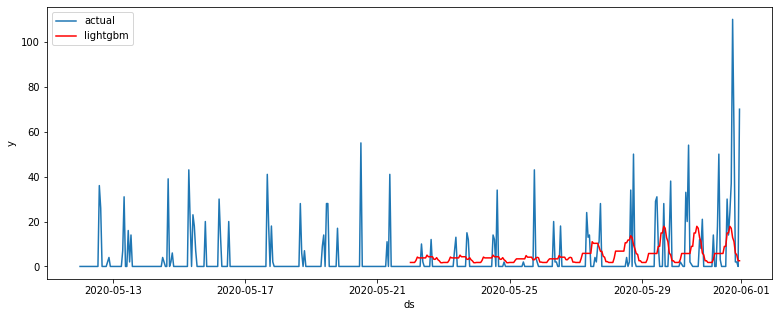

In [22]:
# Создидим датафрейм с почасовой записью данных, используем бустинг для проверки прогнозирования на валидационноай выборке
df['events'] = df['created_at']
df_h = df[['created_at', 'events']].groupby(pd.Grouper(key='created_at', freq='H')).count().reset_index()

df_h.columns = ['ds', 'y']

df_h['date'] = df_h.index
df_h['hour'] = df_h['ds'].dt.hour
df_h['dayofweek'] = df_h['ds'].dt.dayofweek
df_h['month'] = df_h['ds'].dt.month
df_h['year'] = df_h['ds'].dt.year
df_h['dayofyear'] = df_h['ds'].dt.dayofyear
df_h['dayofmonth'] = df_h['ds'].dt.day
df_h['weekofyear'] = df_h['ds'].dt.weekofyear

X = df_h[['hour', 'dayofweek','month','year',
        'dayofyear','dayofmonth','weekofyear']]
y = df_h['y']

X_train, y_train = X[:-240], y[:-240]
X_valid, y_valid = X[-240:], y[-240:]

lgb = lightgbm.LGBMRegressor()
lgb.fit(X_train, y_train, eval_set=(X_valid, y_valid), verbose=False, early_stopping_rounds=2400)
pred = lgb.predict(X_valid)

sns.lineplot(x=df_h['ds'][-2*240:], y=df_h['y'][-2*240:], label='actual')
sns.lineplot(x=df_h['ds'][-240:], y=pred[-240:], color='red', label='lightgbm')

mae_lgb_h = round(mean_absolute_error(y_true=df_h.y[-240:], y_pred=pred[-240:]), 2)
mape_lgb_h = round(mean_absolute_percentage_error(y_true=df_h.y[-240:], y_pred=pred[-240:]), 2)

print(f'Средняя абсолютная ошибка, почасовой прогноз: {mae_lgb_h} или же {mape_lgb_h}%')

### На валидационной выборке результат получился слишком "сглаженным". Для прогноза потребуется бОльшая история (при этом она должна быть более менее однорода, без резких скачков)

## Итоги

Нам удалось обработать данные, чтобы с ними было удобнее работать, изучить и вникнуть в специфику данных, лучше их понять. Получилось произвести кластеризацю, при этом прогнозировать на этих данных пока рановато.

Выводы и рекомендации:
- Обратить внимание на колонку 'status', по всей видимости, она работает некорректно (с задержкой)
- Курсы/активности имеют хороший процент успешного прохождения среди всех пользователей
- Симуляция встречается реже, чем опросы, возможно, чтоит повысить их количество, ведь это кажется самым ценным заданием
- Скорость прогрессирования пользователя по курсу достаточно большая, возможно, стоит добавить больше материала или сделать более продвинутые курсы/актинвости